# EIMS Data
This script will read in the individual EIMS data files from the given directory and compile/prase the data for the model.

In [2]:
## Install the package if needed:
#install.packages('rgdal', repos='http://cran.us.r-project.org')

## Load the relevent packages
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

[1] 3

### File Input

First we need to set the directory and file name criteria of the data to load. We also set the date-time format that the parser will be expecting.

In [3]:
input.dir = './Raw Data/EIMS/'
dt.format = "%m/%d/%y %I:%M %p"

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list.nu = file.list[grepl('not usable', file.list)] # not usable
file.list.2 = file.list[grepl('corr.txt', file.list)] # usable

## Print total number of files in each category
print(paste('Number of files in file.list:', length(file.list)))
print(paste('Number of files in file.list.2:', length(file.list.2)))
print(paste('Number of files in file.list.nu:', length(file.list.nu)))


[1] "Number of files in file.list: 179"
[1] "Number of files in file.list.2: 70"
[1] "Number of files in file.list.nu: 17"


In [4]:
## Read in first data file and configure formatting around it
data = read.csv(paste0(input.dir, file.list.2[1]), sep='\t')
data$time = strptime(data$time, format = dt.format, tz='')

### Main Functions

These functions will do the heavy lifting for the EIMS preparation. The __avg.eims()__ generates the average of N minutes of samples while __filter.eims()__ goes QC type of work by removing high/low pressure samples and handles missing values.

In [5]:
## Average
avg.eims = function(x, N) {
    i = 1
    
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time, x$time[i], unit='mins'))
        l = which(dt >= 0 & dt < N)
        
        ## Calculate the mean of the relevant columns, removing na's
        x[i, 3:ncol(x)] = apply(x[l, 3:ncol(x)], 2, function(x) {mean(x, na.rm = TRUE)})
    
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 1) {
                x = x[-l,]
            }
        }
        i = i + 1
    }
    x
}

## Prepare filter function
filter.eims = function(x, i='Unknown') {
    ## Remove entries where flow not within 5% of 100
    x = x[x$flow < 105 & x$flow > 95,]
    x = x[x$O2.Ar < 30 & x$O2.Ar > 22,]
    
    x[,1] = i
    
    ## Remove first and last minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[1], unit='mins'))^2 < 1)
    if (length(l) > 1) {
        x = x[-l,]
    }
    
    l = which(as.numeric(difftime(x$time, x$time[nrow(x)], unit='mins'))^2 < 1)
    if (length(l) > 1) {
        x = x[-l,]
    }
    
    ## find all valve switches and remove all entries within a miute of it.
    l = which(diff(x$Valve) != 0)
    for (i in l) {
        dt = abs(as.numeric(difftime(x$time[i], x$time, unit='mins')))
        k = which(dt <= 1)
        if (length(k) > 1) {
            x = x[-k,]
        }
    }
    x = x[!is.na(x$O2.Ar),]
    x
}

In [6]:
N = 2 ## Time to avg over (mins)
N.cal = 60  ## Time to avg cal over (mins)


## Create template data structure to add new entries to:
data.v1 = data[1,] # valve = 1
data.v2 = data[1,] # valve = 2

for (i in file.list.2) {
    ## load file and parse the time and filter the values
    data = read.csv(paste0(input.dir, i), sep='\t')
    data$time = strptime(data$time, format = dt.format, tz='')
    data = filter.eims(data)
    print(paste("Loaded file:", i))
    
    #### determine valve = 1 
    l = which(data$Valve == 1)
    temp = avg.eims(data[l,], N)
    
    if (length(names(temp)) == length(names(data.v1))) {
        ## Do the column names match?
        names(temp) = names(data.v1) # Force colname match (dangerous), but will check that lengths are the same
        data.v1 = rbind(data.v1, temp)
        print(paste('  Added', nrow(temp),'to valve 1.'))
    } else {
        print(i)
    }
    
    #### determine valve = 2
    l = which(data$Valve == 2)
    temp = avg.eims(data[l,], N.cal)
    
    if (length(names(temp)) == length(names(data.v2))) {
        ## Do the column names match?
        names(temp) = names(data.v2) # Force colname match (dangerous), but will check that lengths are the same
        data.v2 = rbind(data.v2, temp)
        print(paste('  Added', nrow(temp),'to valve 2.'))
    } else {
        print(i)
    }
    if (length(data$valve) > 1) {
        print(paste("Lower case Valve issue:", i))
    }
}


## Remove the first row used to initiate the table
data.v1 = data.v1[-1,]
data.v2 = data.v2[-1,]
data.v1 = data.v1[,-c(13, 14, 15, 23, 24, 25)]
data.v2 = data.v2[,-c(13, 14, 15, 23, 24, 25)]

[1] "Loaded file: 2017-0601-1200 MID-valve corr.txt"
[1] "  Added 41 to valve 1."
[1] "  Added 0 to valve 2."
[1] "Loaded file: 2017-0601-2031 MID-valve corr.txt"
[1] "  Added 74 to valve 1."
[1] "  Added 2 to valve 2."
[1] "Loaded file: 2017-0602-0000 MID-valve corr.txt"
[1] "  Added 311 to valve 1."
[1] "  Added 3 to valve 2."
[1] "Loaded file: 2017-0602-1200 MID-valve corr.txt"
[1] "  Added 75 to valve 1."
[1] "  Added 0 to valve 2."
[1] "Loaded file: 2017-0602-1449 MID-valve corr.txt"
[1] "  Added 220 to valve 1."
[1] "  Added 1 to valve 2."
[1] "Loaded file: 2017-0603-1200 MID-valve corr.txt"
[1] "  Added 48 to valve 1."
[1] "  Added 0 to valve 2."
[1] "Loaded file: 2017-0603-1347 MID-valve corr.txt"
[1] "  Added 56 to valve 1."
[1] "  Added 0 to valve 2."
[1] "Loaded file: 2017-0603-1548 MID-valve corr.txt"
[1] "  Added 118 to valve 1."
[1] "  Added 2 to valve 2."
[1] "Loaded file: 2017-0604-0448 MID-TBK-valve corr.txt"
[1] "  Added 935 to valve 1."
[1] "  Added 19156 to valve 2.

In [7]:
## Also, correct the time since the year is not actuall 2021...
data.v1$time = data.v1$time - 4 * 365.25 * 86400
data.v2$time = data.v2$time - 4 * 365.25 * 86400

## Remove NA O2:Ar values
data.v1 = data.v1[which(!is.na(data.v1$O2.Ar)),]
data.v2 = data.v2[which(!is.na(data.v2$O2.Ar)),]

## Number of entries, do they seem right?
nrow(data.v1)
nrow(data.v2)

[1] 12634

[1] 141

In [8]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,553753,29.6,1442291,77.1,1364181,72.9
Vcells,1620606,12.4,19582208,149.5,24477760,186.8


## Review results

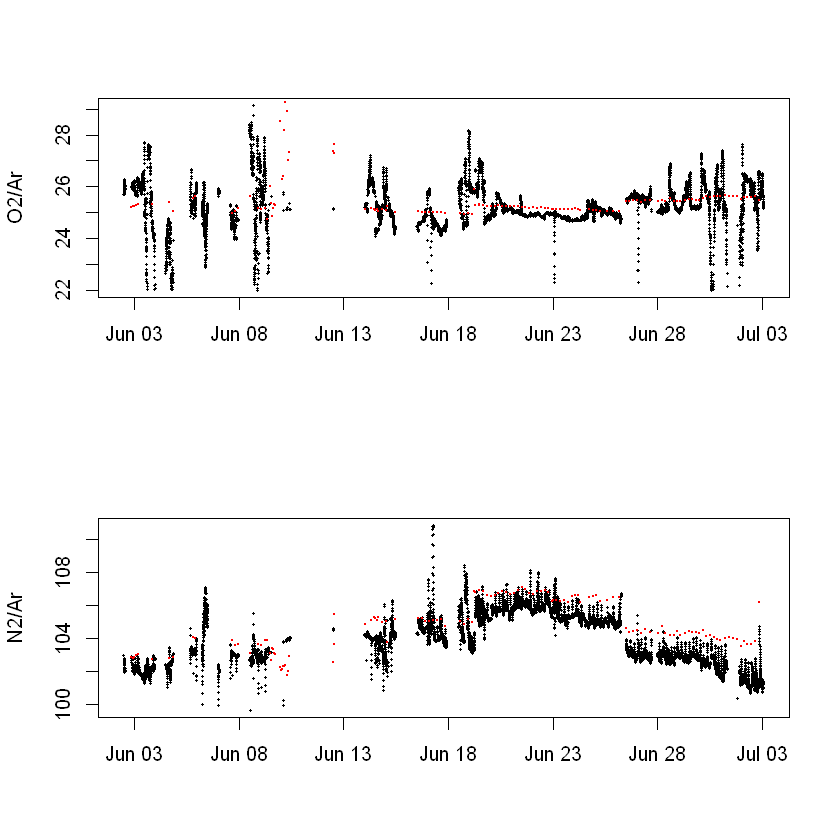

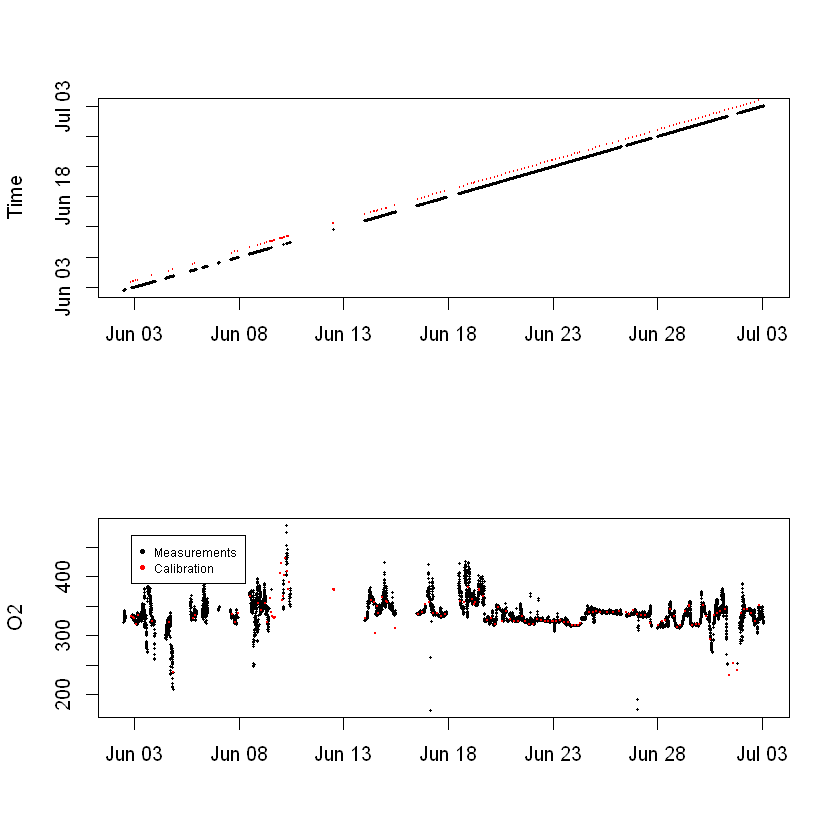

In [9]:
#pdf('./Output/Generate-EIMS-review1.pdf')

par(mfrow=c(2,1))
l = order(data.v1$time)
ll = order(data.v2$time)

plot(data.v1$time[l], data.v1$O2.Ar[l], pch=16, cex=0.3, ylab='O2/Ar', xlab='')
points(data.v2$time[ll], data.v2$O2.Ar[ll], pch=16, cex=0.2, col='red')

legend(data.v1$time[1], 19, c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16, cex=0.6)

plot(data.v1$time[l], data.v1$N2.Ar[l], pch=16, cex=0.3, ylab='N2/Ar', xlab='')
points(data.v2$time[ll], data.v2$N2.Ar[ll], pch=16, cex=0.2, col='red')

plot(data.v1$time[l], data.v1$time[l], pch=16, cex=0.3, ylab='Time', xlab='')
points(data.v2$time[ll], data.v2$time[ll]+86400, cex=0.2, col='red')

plot(data.v1$time[l], data.v1$O2..uM.[l], pch=16, cex=0.3, ylab='O2', xlab='')
points(data.v2$time[ll], data.v2$O2..uM.[ll], pch=16, cex=0.2, col='red')

legend(data.v2$time[1], 470, c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16, cex=0.6)

#dev.off()

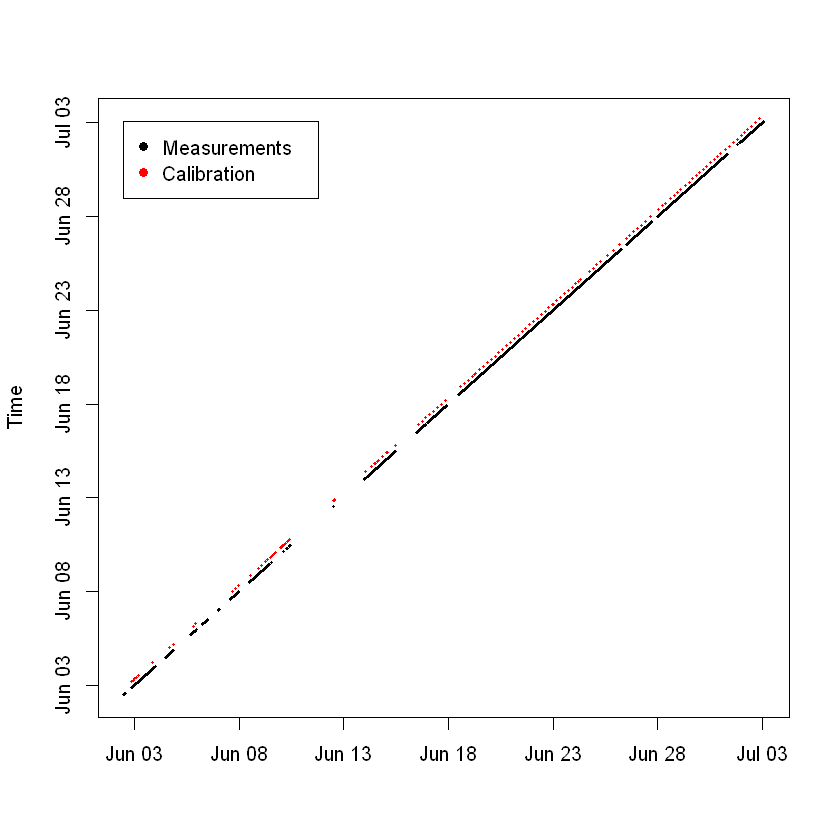

In [10]:
#pdf('./Output/Generate-EIMS-review2.pdf')

plot(data.v1$time[l], data.v1$time[l], pch=16, cex=0.3, ylab='Time', xlab='')
points(data.v2$time[ll], data.v2$time[ll]+86400/3, pch=16, cex=0.3, col='red')
legend(data.v1$time[1], data.v1$time[nrow(data.v1)], c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16)

#dev.off()

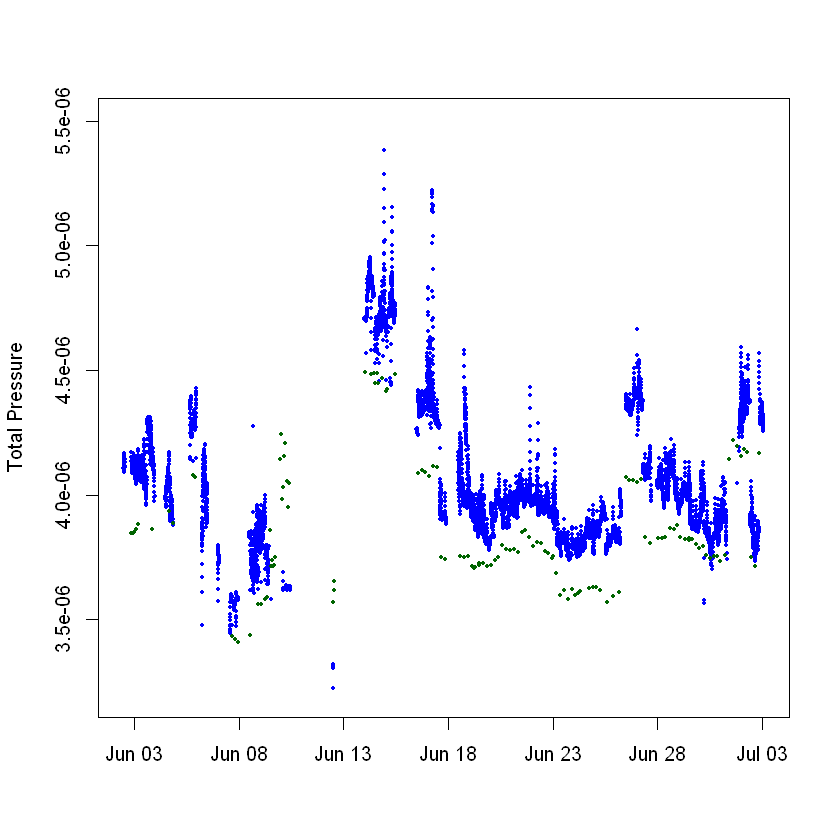

In [11]:
plot(data.v1$time, data.v1$TP, col='white', ylim=c(3.2e-6, 5.5e-6), ylab='Total Pressure', xlab='')

col = c('Black', 'blue', 'grey', 'dark green')

for (i in 1:length(unique(data.v1[,1]))) {
    l = which(data.v1[,1] == unique(data.v1[,1])[i])
    points(data.v1$time[l], data.v1$TP[l], col=col[i %% 2 + 1], pch=20, cex=0.6)
}

for (i in 1:length(unique(data.v2[,1]))) {
    l = which(data.v2[,1] == unique(data.v2[,1])[i])
    points(data.v2$time[l], data.v2$TP[l], col=col[i %% 2 + 3], pch=20, cex=0.6)
}


# Save

In [12]:
## Save the data
eims.v1 = data.v1
eims.v2 = data.v2
save(eims.v1, file='./RStates/EIMS.v1.2min.rdata')
save(eims.v2, file='./RStates/EIMS.v2.60min.rdata')

## Optional
write.csv(data.v1, './Input Data/EIMS-Valve1.2min.csv')
write.csv(data.v2, './Input Data/EIMS-Valve2.60min.csv')

---
# Damaged/Unusable data file recovery

In [100]:
## Create template data structure to add new entries to:
data.v3 = data[1,] # valve = 1
data.v4 = data[1,] # valve = 2

for (i in file.list.nu) {
    ## load file and parse the time
    data = read.csv(paste0(input.dir, i), sep='\t')
    data$time = strptime(data$time, format = dt.format, tz='')
    
    ## determine valve = 1 
    l = which(data$Valve == 1)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v1))) {
        names(temp) = names(data.v3) # Force colname match (dangerous), but will check that lengths are the same
        data.v3 = rbind(data.v3, temp)
    } else {
        print(i)
    }
    
    ## determine valve = 2
    l = which(data$Valve == 2)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v4))) {
        names(temp) = names(data.v4) # Force colname match (dangerous), but will check that lengths are the same
        data.v4 = rbind(data.v4, temp)
    } else {
        print(i)
    }
    if (length(data$valve) > 1) {
        print(paste("Lower case Valve issue:", i))
    }
}


## Remove the first row used to initiate the table
data.v3 = data.v3[-1,]
data.v4 = data.v4[-1,]
data.v3 = data.v3[,-c(1, 13, 14, 15, 23, 24, 25)]
data.v4 = data.v4[,-c(1, 13, 14, 15, 23, 24, 25)]

[1] "2017-0603-2102 MID-valve corr not usable 2.txt"
[1] "2017-0603-2102 MID-valve corr not usable.txt"
[1] "2017-0604-0000 MID-valve corr - not usable 2.txt"
[1] "2017-0604-0000 MID-valve corr - not usable.txt"
[1] "2017-0604-0448 MID-valve corr not usable 2.txt"
[1] "2017-0604-0448 MID-valve corr not usable.txt"
[1] "2017-0605-0000 MID-valve corr not usable 2.txt"
[1] "2017-0605-0000 MID-valve corr not usable.txt"
[1] "2017-0605-0407 MID-valve corr - not usable short 2.txt"
[1] "2017-0605-0407 MID-valve corr - not usable short.txt"
[1] "2017-0605-0413 MID-valve corr not usable short 2.txt"
[1] "2017-0605-0413 MID-valve corr not usable short.txt"
[1] "2017-0605-0440 MID-valve corr- not usable 2.txt"
[1] "Lower case Valve issue: 2017-0605-0440 MID-valve corr- not usable 2.txt"
[1] "2017-0605-0440 MID-valve corr- not usable.txt"
[1] "Lower case Valve issue: 2017-0605-0440 MID-valve corr- not usable.txt"
[1] "2017-0606-1200 MID-valve corrnot usable 2.txt"
[1] "2017-0606-1200 MID-valve co